In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')


def save_fig(fig,
    path: Path, fig_id: str, tight_layout : bool = True, fig_extension: str = "pdf",
        resolution: int = 300) -> None:
    """
    coherent saving of matplotlib figures as pdfs (default)
    :rtype: object
    :param path: path for saving
    :param fig_id: name of saved figure
    :param tight_layout: option, default True
    :param fig_extension: option, default pdf
    :param resolution: option, default 300dpi
    :return: None, saves Figure in poth
    """

    dest = path / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        fig.set_tight_layout(True)
    plt.savefig(dest, format=fig_extension, dpi=resolution, facecolor='white')
path = Path.cwd() / "data" 
path.mkdir(exist_ok=True)
home_dir = Path.home()
style_path = home_dir / 'matplotlib_style/Style_03_fig.mplstyle'
plt.style.use(style_path)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

The Style_03_fig.mplstyle contains a lot of styling information for matplotlib figures.
Have a look at this and play around with it! I set this up so that the font sizes are
compatible with general figure styles for papers, so quite small.
Using the style sheet you can take more or less total control of how you plot will look like.

In [2]:
# Specify the directory containing the CSV file
directory = Path.cwd()

if csv_files := list(directory.glob("*.csv")):
    # There should be only one CSV file in the directory
    csv_file = csv_files[0]

    # Read the CSV file
    df = pd.read_csv(csv_file, index_col=0)

In [3]:
df.columns

Index(['experiment', 'well', 'cell_line', 'gwli', 'dox', 'label',
       'area_nucleus', 'intensity_max_DAPI_nucleus',
       'intensity_min_DAPI_nucleus', 'intensity_mean_DAPI_nucleus',
       'centroid-0', 'centroid-1', 'Cyto_ID', 'integrated_int_DAPI',
       'area_cell', 'intensity_max_DAPI_cell', 'intensity_min_DAPI_cell',
       'intensity_mean_DAPI_cell', 'centroid-0_x', 'centroid-1_x', 'area_cyto',
       'intensity_max_DAPI_cyto', 'intensity_min_DAPI_cyto',
       'intensity_mean_DAPI_cyto', 'centroid-0_y', 'centroid-1_y',
       'intensity_max_Tub_nucleus', 'intensity_min_Tub_nucleus',
       'intensity_mean_Tub_nucleus', 'intensity_max_Tub_cell',
       'intensity_min_Tub_cell', 'intensity_mean_Tub_cell',
       'intensity_max_Tub_cyto', 'intensity_min_Tub_cyto',
       'intensity_mean_Tub_cyto', 'intensity_max_H2AX_nucleus',
       'intensity_min_H2AX_nucleus', 'intensity_mean_H2AX_nucleus',
       'intensity_max_H2AX_cell', 'intensity_min_H2AX_cell',
       'intensity_mean

all functions I wrote are based on a categorical column "condition". 
This can then be turned into a list with a specific order to show the relevant results 
in a logical sequence.
In many cases the treatments are more complex that a single condition. So here for example we
have two treatments Dox and Gwli. So we need to combine this into a single condition column. This is what the
next line achieves.
This may be tricky to understand (apply and lambda functions are not thinsg we use every day)
But if you use code, try to understand what it does. If you feed this line to ChatGTO it will
give you a breakdown of whats going on.

In [4]:
df['condition'] = df.apply(lambda row: f"gwli {row['gwli']}; dox {row['dox']}", axis=1)

In [5]:
df['cell_line'].unique()

array(['RPE-1_WT', 'RPE-1_P53KO', 'RPE-1_WT_CycE', 'RPE-1_P53KO_CycE'],
      dtype=object)

Also the experiment has several cell lines so lets trim down the data to the specific cell lines

In [6]:
df_WT = df[df['cell_line'] == 'RPE-1_WT']



In [7]:
conditions = list(df['condition'].unique())
conditions

['gwli -; dox -', 'gwli +; dox -', 'gwli -; dox +', 'gwli +; dox +']

Next we are building a pretty complex plot to show the Histgram, and Edu scatter plot as well as
H2AX scatter plot. This is a lot of code and more or less my current limit of what I can do with matplotlib.
Another challenge is to generate functions that work on different data sets so that you dont need to change too much.
However, there will always be scenarios where you have to adapt the function to a specific case and get an optimal
Figure out. So its important you understand each step.

## 1) Histogram.
I set each subplot up as an individual Figure that can be applied to many differnet axes using the 'ax' parameter.
You will have seen this a lot: fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(3,3))
Here is a good breakdown of what is actually happening here:
https://towardsdatascience.com/clearing-the-confusion-once-and-for-all-fig-ax-plt-subplots-b122bb7783ca
This is a core concept in matplotlib and important to understand

In [8]:
def plot_histogram(ax, i, data):
    sns.histplot(
        data=data, x="integrated_int_DAPI_norm", ax=ax, color=colors[-1]
    )
    ax.set_xlabel(None)
    ax.set_xscale("log", base=2)
    ax.set_xlim([1, 16])
    ax.xaxis.set_visible(False)
    if i == 0:
        ax.set_ylabel("Freq.", fontsize=6)
    else:
        ax.yaxis.set_visible(False)
    ax.tick_params(axis="both", which="major", labelsize=6)

So how could we use this function to generate a row of histograms?

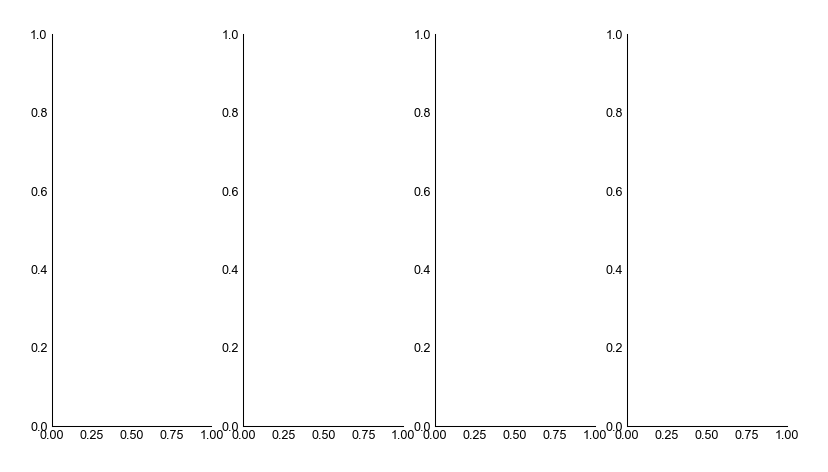

In [9]:
conditions = list(df.condition.unique())
fig, ax = plt.subplots(ncols=len(conditions), figsize=(5, 3))
for i, condition in enumerate(conditions):
    df1 = df_WT[df_WT.condition == condition]
    # your code

Problems with this Figure:
There is no x-axis label.
The figure could do with a title
It's probably a good idea to save this figure!

## 2) Edu/PI Scatterplot
The next Figure is the EdU scatterplot
This work pretty much in the same way as the previous plot

In [13]:
def plot_scatter(ax, i, data, conditions):
    phases = ["Sub-G1", "G1", "S", "G2/M", "Polyploid"]
    sns.scatterplot(
        data=data,
        x="integrated_int_DAPI_norm",
        y="intensity_mean_EdU_nucleus_norm",
        hue="cell_cycle",
        hue_order=phases,
        s=2,
        alpha=1,
        ax=ax,
    )
    ax.set_xscale("log")
    ax.set_yscale("log", base=2)
    ax.grid(False)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: str(int(x)))
    )
    ax.set_xticks([2, 4, 8])
    ax.set_xlim([1, 16])
    if i == len(conditions):
        ax.set_ylabel("norm. EdU int.", fontsize=6)
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, pos: str(int(x)))
        )
    else:
        ax.yaxis.set_visible(False)
    ax.legend().remove()
    ax.set_xlabel(None)
    ax.axvline(x=3, color="black", linestyle="--")
    ax.axhline(y=3, color="black", linestyle="--")
    sns.kdeplot(
        data=data,
        x="integrated_int_DAPI_norm",
        y="intensity_mean_EdU_nucleus_norm",
        fill=True,
        alpha=0.3,
        cmap="rocket_r",
        ax=ax,
    )
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.set_xlabel(None)

In [14]:
#Your code to call the function


How can you reduce the number of cells in this plot?
Why is the y-axis not labeled?
Can you identify the problem with the y-axis label in the function and fix it?


## Feature Scatterplot
The next function is set up to plot specific features (col parameter) scattered across the PI intensity on the x axis. This pretty useful for analysing different aspects of the IF data.

In [15]:
def plot_scatter_col(ax, i, data, conditions, col):
    data["color"] = data[col].apply(
        lambda x: colors[0] if x < 4000 else colors[1]
    )
    sns.scatterplot(
        data=data,
        x="integrated_int_DAPI_norm",
        y=col,
        hue="color",
        palette=[colors[-1], colors[1]],
        hue_order=[colors[-1], colors[1]],
        s=2,
        alpha=1,
        ax=ax,
    )
    ax.set_xscale("log")
    ax.set_yscale("log", base=2)
    ax.grid(False)
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: str(int(x)))
    )
    ax.set_xticks([2, 4, 8])
    ax.set_xlim([1, 16])

    # Set specific y-axis ticks and labels
    ax.set_yticks([2000, 4000, 8000, 16000])
    ax.set_yticklabels(["2", "4", "8", "16"])

    if i == len(conditions) * 2:
        ax.set_ylabel(f"{col}", fontsize=6)
        #Custom y-axis formatter to remove zeros
        ax.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda y, _: f"{y / 1000:g}")
        )
    else:
        ax.yaxis.set_visible(False)

    ax.legend().remove()
    ax.set_xlabel(None)
    ax.axvline(x=3, color="black", linestyle="--")
    ax.axhline(y=3, color="black", linestyle="--")
    sns.kdeplot(
        data=data,
        x="integrated_int_DAPI_norm",
        y=col,
        fill=True,
        alpha=0.3,
        cmap="rocket_r",
        ax=ax,
    )
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.set_xlabel(None)

In [17]:
# Your code

This needs a lot of work. What can you do to sort out the y-axis min and max values? Also legends, titles etc need a lot of work